In [1]:
import os 

import torch
from torch import nn
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torchvision.models import vgg16, VGG16_Weights

from torch.utils.data import DataLoader
from torch.optim import SGD, Adam

from torchsummary import summary

import matplotlib.pyplot as plt

from tqdm import tqdm

import numpy as np

d:\conda\envs\torch-light\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ToNumpy(object):
    def __call__(self, image):
        self.image = image
        self.image = np.array(self.image)
        return torch.tensor(self.image)
    
class NoVoid(object):
    def __call__(self, tensor):
        return torch.where(tensor==255, 0, tensor)
    
class OneHot(object):
    def __call__(self, tensor):
        shape = tensor.shape
        tensor = tensor.to(torch.int64)
        # one hot : (B, C=num_classes, H, W)
        one_hot = torch.zeros((shape[0], 21) + shape[1:])
        
        # labels : (B, H, W)
        # labels.unsqueeze(1) : (B, C=1, H, W)
        # ret : (B, C=num_classes, H, W)
        ret = one_hot.scatter_(1, tensor.unsqueeze(1), 1.0)
        return ret.transpose(0, 1)



In [3]:
transform1 = Compose([Resize((224, 224)), ToTensor(), Normalize(mean=[0.4538, 0.4416, 0.4077], std=[0.2631, 0.2597, 0.2765])])
transform2 = Compose([Resize((224, 224)), ToTensor(), Normalize(mean=[0.4563, 0.4381, 0.3995], std=[0.2614, 0.2595, 0.2757])])
target_transform = Compose([Resize((224, 224)),ToNumpy(), NoVoid(), OneHot()])

In [4]:
ds = VOCSegmentation("./data", year="2011", image_set="train", download=False, transform=transform1, target_transform=target_transform)
ds_val = VOCSegmentation("./data_val", year="2011", image_set="val", download=False, transform=transform2, target_transform=target_transform)

In [42]:
def batch_mean_and_sd(loader):
    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(
      snd_moment - fst_moment ** 2)        
    return mean,std

In [43]:
ds[0][0].shape

torch.Size([3, 224, 224])

In [44]:
ds[0][1].shape

torch.Size([21, 224, 224])

In [6]:
fcn_vgg16 = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

def new_forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.features(x)
    x = self.classifier(x)
    return x

bound_method = new_forward.__get__(fcn_vgg16, fcn_vgg16.__class__)
setattr(fcn_vgg16, 'forward', bound_method)

# fcn_vgg16.features[0] = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))

fcn_vgg16.classifier = nn.Sequential(
    nn.Conv2d(512, 4096, (1, 1)),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Conv2d(4096, 4096, (1, 1)),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Conv2d(4096, 21, (1, 1)),
    nn.ConvTranspose2d(21, 21, (32, 32), stride=32, bias=False)
)

for name, module in fcn_vgg16.classifier.named_modules():
    if name == '6':
        module.weight.data.zero_()


In [46]:
summary(fcn_vgg16, (3, 256, 256), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [47]:
train_dataloader = DataLoader(ds, batch_size=20, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(ds_val, batch_size=20, shuffle=True, drop_last=True)

In [48]:
train_losslist = []
val_losslist = []
device = "cuda"
fcn_vgg16.to(device)
# optimizer = SGD(fcn_vgg16.parameters(), 1e-4, momentum=0.9, weight_decay=5**-4)
optimizer = Adam(fcn_vgg16.parameters(), lr=1e-5)
epochs = 200
loss = nn.BCEWithLogitsLoss()

patience = 20
earlystop_counter = 0
best_loss = np.inf

epoch_start = 1

for i in range(epoch_start, epochs+1):
    print("-----------------------------")
    print(f"epoch {i}")
    fcn_vgg16.train()
    loss_sum = 0
    for batch, (X, y) in enumerate(tqdm(train_dataloader)):
        X = X.to(device)
        y = y.to(device)
        pred = fcn_vgg16(X)
        loss_out = loss(pred, y)
        
        optimizer.zero_grad()
        loss_out.backward()
        optimizer.step()
        loss_sum += loss_out.item()
    train_losslist.append(loss_sum/len(train_dataloader))
    print(f"total loss : {loss_sum/len(train_dataloader)}")
    
    fcn_vgg16.eval()
    loss_sum = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(tqdm(valid_dataloader)):
            X = X.to(device)
            y = y.to(device)
            pred = fcn_vgg16(X)
            loss_sum += loss(pred, y).item()
        val_loss = loss_sum/len(valid_dataloader)
        val_losslist.append(val_loss)
        print(f"val loss : {val_loss}")
        
        if best_loss > val_loss:
            print(f"validation loss imporved : {best_loss} -> {val_loss}")
            best_loss = val_loss
            earlystop_counter = 0
            torch.save(fcn_vgg16.state_dict(), "best.pt")
        else:
            earlystop_counter+=1
        
        if earlystop_counter == patience:
            print(f"No validation improvement until {earlystop_counter} epoch. Terminating training loop.")
            fcn_vgg16.load_state_dict("best.pt")
            break
        
    torch.save({
        'epoch': i,
        'model_state_dict': fcn_vgg16.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_losslist,
        'val_loss': val_losslist,
        'earlystop': {'patience': patience, 'counter': earlystop_counter, 'bestloss': best_loss}
    }, os.path.normpath(f"saved/checkpoint_model_{i}.pt"))
    
    try:
        os.remove(os.path.normpath(f"saved/checkpoint_model_{i-1}.pt"))
    except OSError:
        pass

    print("")
            
            
        

-----------------------------
epoch 1


100%|██████████| 55/55 [01:00<00:00,  1.10s/it]


total loss : 0.6518400268121199


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


val loss : 0.5106293049725619
validation loss imporved : inf -> 0.5106293049725619

-----------------------------
epoch 2


100%|██████████| 55/55 [01:01<00:00,  1.12s/it]


total loss : 0.31996166624806144


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]


val loss : 0.17652808156880465
validation loss imporved : 0.5106293049725619 -> 0.17652808156880465

-----------------------------
epoch 3


100%|██████████| 55/55 [01:02<00:00,  1.13s/it]


total loss : 0.12183460105549206


100%|██████████| 55/55 [00:31<00:00,  1.74it/s]


val loss : 0.09509964449839159
validation loss imporved : 0.17652808156880465 -> 0.09509964449839159

-----------------------------
epoch 4


100%|██████████| 55/55 [01:03<00:00,  1.15s/it]


total loss : 0.08565990254282951


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


val loss : 0.08368568549102003
validation loss imporved : 0.09509964449839159 -> 0.08368568549102003

-----------------------------
epoch 5


100%|██████████| 55/55 [01:02<00:00,  1.14s/it]


total loss : 0.07888671423901211


100%|██████████| 55/55 [00:31<00:00,  1.74it/s]


val loss : 0.08006358735940673
validation loss imporved : 0.08368568549102003 -> 0.08006358735940673

-----------------------------
epoch 6


100%|██████████| 55/55 [01:02<00:00,  1.13s/it]


total loss : 0.07653523256832903


100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


val loss : 0.07884981056505984
validation loss imporved : 0.08006358735940673 -> 0.07884981056505984

-----------------------------
epoch 7


100%|██████████| 55/55 [01:02<00:00,  1.14s/it]


total loss : 0.0750621726567095


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


val loss : 0.07775375585664403
validation loss imporved : 0.07884981056505984 -> 0.07775375585664403

-----------------------------
epoch 8


100%|██████████| 55/55 [01:01<00:00,  1.13s/it]


total loss : 0.0745532552627


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


val loss : 0.07709547172893177
validation loss imporved : 0.07775375585664403 -> 0.07709547172893177

-----------------------------
epoch 9


100%|██████████| 55/55 [01:04<00:00,  1.18s/it]


total loss : 0.07369335104118693


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


val loss : 0.07685976319692352
validation loss imporved : 0.07709547172893177 -> 0.07685976319692352

-----------------------------
epoch 10


100%|██████████| 55/55 [01:02<00:00,  1.14s/it]


total loss : 0.07357709455219182


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


val loss : 0.07632218714464795
validation loss imporved : 0.07685976319692352 -> 0.07632218714464795

-----------------------------
epoch 11


100%|██████████| 55/55 [01:02<00:00,  1.14s/it]


total loss : 0.0723837859928608


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


val loss : 0.07682312787933783

-----------------------------
epoch 12


100%|██████████| 55/55 [01:04<00:00,  1.16s/it]


total loss : 0.0718822185288776


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]


val loss : 0.07587178505279801
validation loss imporved : 0.07632218714464795 -> 0.07587178505279801

-----------------------------
epoch 13


100%|██████████| 55/55 [01:01<00:00,  1.12s/it]


total loss : 0.07140826670960947


100%|██████████| 55/55 [00:32<00:00,  1.72it/s]


val loss : 0.07535238706252792
validation loss imporved : 0.07587178505279801 -> 0.07535238706252792

-----------------------------
epoch 14


100%|██████████| 55/55 [01:03<00:00,  1.15s/it]


total loss : 0.07096711227839643


100%|██████████| 55/55 [00:31<00:00,  1.75it/s]


val loss : 0.07520894834941083
validation loss imporved : 0.07535238706252792 -> 0.07520894834941083

-----------------------------
epoch 15


100%|██████████| 55/55 [01:07<00:00,  1.22s/it]


total loss : 0.0702067803252827


100%|██████████| 55/55 [00:34<00:00,  1.62it/s]


val loss : 0.07530391744591973

-----------------------------
epoch 16


100%|██████████| 55/55 [01:02<00:00,  1.14s/it]


total loss : 0.06928035312078216


100%|██████████| 55/55 [00:31<00:00,  1.74it/s]


val loss : 0.07533187615600499

-----------------------------
epoch 17


100%|██████████| 55/55 [01:03<00:00,  1.16s/it]


total loss : 0.06847598749128254


100%|██████████| 55/55 [00:35<00:00,  1.56it/s]


val loss : 0.07357362454587763
validation loss imporved : 0.07520894834941083 -> 0.07357362454587763

-----------------------------
epoch 18


100%|██████████| 55/55 [01:02<00:00,  1.13s/it]


total loss : 0.06724886277859861


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


val loss : 0.07321250614794818
validation loss imporved : 0.07357362454587763 -> 0.07321250614794818

-----------------------------
epoch 19


100%|██████████| 55/55 [01:02<00:00,  1.15s/it]


total loss : 0.06667675491083752


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]


val loss : 0.07353824546391313

-----------------------------
epoch 20


100%|██████████| 55/55 [01:03<00:00,  1.16s/it]


total loss : 0.06595201336524703


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


val loss : 0.07389526299454949

-----------------------------
epoch 21


100%|██████████| 55/55 [01:02<00:00,  1.14s/it]


total loss : 0.06526334969834847


100%|██████████| 55/55 [00:35<00:00,  1.55it/s]


val loss : 0.07394550137899139

-----------------------------
epoch 22


100%|██████████| 55/55 [01:04<00:00,  1.17s/it]


total loss : 0.06451053626158021


100%|██████████| 55/55 [00:31<00:00,  1.75it/s]


val loss : 0.0718825063244863
validation loss imporved : 0.07321250614794818 -> 0.0718825063244863

-----------------------------
epoch 23


100%|██████████| 55/55 [01:01<00:00,  1.11s/it]


total loss : 0.06396323056383567


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


val loss : 0.07193293950774453

-----------------------------
epoch 24


100%|██████████| 55/55 [01:04<00:00,  1.17s/it]


total loss : 0.0633847786621614


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


val loss : 0.07269704782150009

-----------------------------
epoch 25


100%|██████████| 55/55 [01:02<00:00,  1.13s/it]


total loss : 0.06294842050834136


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


val loss : 0.07472329857674512

-----------------------------
epoch 26


100%|██████████| 55/55 [01:02<00:00,  1.13s/it]


total loss : 0.06233523921533064


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


val loss : 0.07147709449583833
validation loss imporved : 0.0718825063244863 -> 0.07147709449583833

-----------------------------
epoch 27


100%|██████████| 55/55 [01:02<00:00,  1.13s/it]


total loss : 0.06175856238061732


100%|██████████| 55/55 [00:31<00:00,  1.74it/s]


val loss : 0.07188579162413423

-----------------------------
epoch 28


100%|██████████| 55/55 [01:03<00:00,  1.15s/it]


total loss : 0.061576140604235906


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


val loss : 0.07188077216798609

-----------------------------
epoch 29


100%|██████████| 55/55 [01:03<00:00,  1.16s/it]


total loss : 0.06104097657582976


100%|██████████| 55/55 [00:33<00:00,  1.63it/s]


val loss : 0.0714994487437335

-----------------------------
epoch 30


100%|██████████| 55/55 [01:04<00:00,  1.16s/it]


total loss : 0.06079690713774074


100%|██████████| 55/55 [00:31<00:00,  1.74it/s]


val loss : 0.07166651656681841

-----------------------------
epoch 31


100%|██████████| 55/55 [01:02<00:00,  1.13s/it]


total loss : 0.06017497913403944


100%|██████████| 55/55 [00:31<00:00,  1.72it/s]


val loss : 0.07228021838448265

-----------------------------
epoch 32


100%|██████████| 55/55 [01:02<00:00,  1.13s/it]


total loss : 0.05983257761055773


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


val loss : 0.07179849147796631

-----------------------------
epoch 33


100%|██████████| 55/55 [01:03<00:00,  1.16s/it]


total loss : 0.05929354239593853


100%|██████████| 55/55 [00:33<00:00,  1.65it/s]


val loss : 0.07535337263887579

-----------------------------
epoch 34


100%|██████████| 55/55 [01:04<00:00,  1.16s/it]


total loss : 0.05925062664530494


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


val loss : 0.07219392440535806

-----------------------------
epoch 35


100%|██████████| 55/55 [01:02<00:00,  1.14s/it]


total loss : 0.05872414796189828


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]


val loss : 0.07235184799541126

-----------------------------
epoch 36


100%|██████████| 55/55 [01:03<00:00,  1.15s/it]


total loss : 0.05856415175578811


100%|██████████| 55/55 [00:31<00:00,  1.74it/s]


val loss : 0.07214452299204739

-----------------------------
epoch 37


100%|██████████| 55/55 [01:03<00:00,  1.16s/it]


total loss : 0.05789002098820426


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


val loss : 0.0749556155367331

-----------------------------
epoch 38


100%|██████████| 55/55 [01:03<00:00,  1.16s/it]


total loss : 0.05785213126377626


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


val loss : 0.07244345505129207

-----------------------------
epoch 39


100%|██████████| 55/55 [01:01<00:00,  1.13s/it]


total loss : 0.05758386809717525


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


val loss : 0.07250064679167488

-----------------------------
epoch 40


100%|██████████| 55/55 [01:02<00:00,  1.13s/it]


total loss : 0.05715546330267733


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


val loss : 0.07289531969211319

-----------------------------
epoch 41


100%|██████████| 55/55 [01:03<00:00,  1.16s/it]


total loss : 0.05704233246770772


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


val loss : 0.07274593372236599

-----------------------------
epoch 42


100%|██████████| 55/55 [01:00<00:00,  1.11s/it]


total loss : 0.05679868148131804


100%|██████████| 55/55 [00:31<00:00,  1.75it/s]


val loss : 0.07169238952073184

-----------------------------
epoch 43


100%|██████████| 55/55 [01:03<00:00,  1.15s/it]


total loss : 0.05652943720871752


100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


val loss : 0.07421650331128728

-----------------------------
epoch 44


100%|██████████| 55/55 [01:03<00:00,  1.15s/it]


total loss : 0.056029462882063605


100%|██████████| 55/55 [00:32<00:00,  1.67it/s]


val loss : 0.07384310852397571

-----------------------------
epoch 45


100%|██████████| 55/55 [01:04<00:00,  1.17s/it]


total loss : 0.055976850336248225


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


val loss : 0.0723318446088921

-----------------------------
epoch 46


100%|██████████| 55/55 [01:01<00:00,  1.12s/it]


total loss : 0.055734663659876046


100%|██████████| 55/55 [00:31<00:00,  1.74it/s]

val loss : 0.07558375136418775
No validation improvement until 20 epoch. Terminating training loop.


TypeError: Expected state_dict to be dict-like, got <class 'str'>.

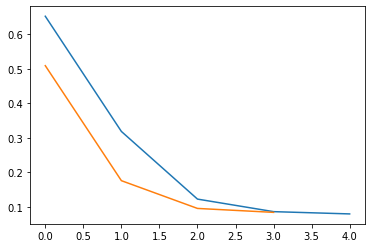

In [ ]:
plt.plot(train_losslist)
plt.plot(val_losslist)

In [5]:
checkpoint = torch.load("best.pt")

In [14]:
fcn_vgg16.load_state_dict(checkpoint)

<All keys matched successfully>

In [15]:
fcn_vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


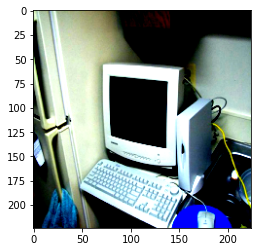

In [22]:
plt.imshow(ds[1][0].permute(1, 2, 0))

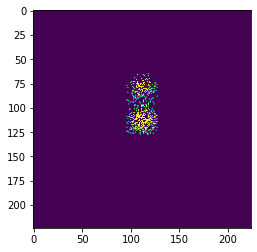

In [23]:
output = fcn_vgg16(ds[1][0].to(device))
plt.imshow(output.argmax(axis=0).cpu())